# IMPORTING DATA AND ADDING FEATURE

## importing Data

In [25]:

#importing library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
#importing dataset
df = pd.read_csv(r'E:\major_project\datasets\rockyou_balanced.csv', encoding='latin-1')

## OverView of DataSet

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440455 entries, 0 to 440454
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  440454 non-null  object
 1   strength  440455 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.7+ MB


In [5]:
df.sample(20)

,password,strength
400178,cshluvesdww,4
238204,47739679,2
22664,b0yb0y,0
138677,402654,1
304552,Wob2n1ar6,3
300738,chevere148,3
136750,4206081,1
200200,80194314,2
21606,m0ntg0mery,0
71795,1038284,1


Text(0.5, 1.0, 'Distribution of Password Strength')

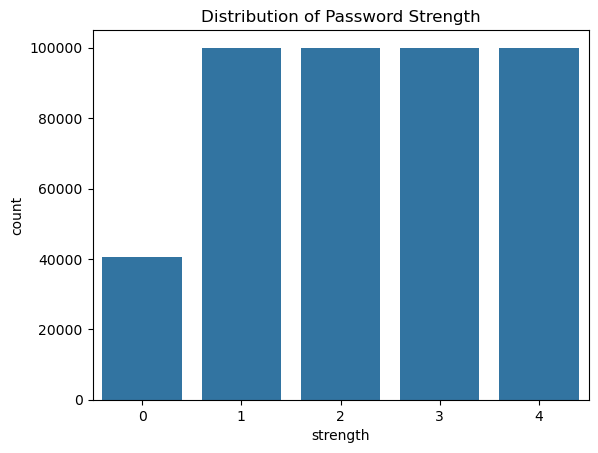

In [7]:
#checking distribtion of target variable
sns.countplot(x='strength', data=df)
plt.title('Distribution of Password Strength')

Most of the password strength are distrbuted evenly except the one with strength 0, due to lack of data. Learning from past notebooks, we will convert the five strength values into three, which will give better results for the user.

## basic data preprocessing

In [8]:
# checking for null values
df.isnull().sum()

password    1
strength    0
dtype: int64

In [9]:
#removing null values and converting to string
df.dropna(subset=['password'], inplace=True)
df['password'] = df['password'].astype(str)

In [10]:
#checking for duplicates
df.duplicated().sum()

350

In [11]:
#removing duplicates
df.drop_duplicates(subset=['password'], inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440104 entries, 0 to 440454
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  440104 non-null  object
 1   strength  440104 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ MB


In [14]:
df['strength'].value_counts()

strength
1    100000
2    100000
3    100000
4    100000
0     40104
Name: count, dtype: int64

In [16]:
df.shape

(440104, 2)

In [17]:
#removing invisible control characters
df = df[~df["password"].str.contains(r'[\x00-\x1F\x7F-\x9F]', na=True, regex=True)]

In [18]:
#adding length column, and removing passwords with length >=50
df['password'] = df['password'].str.strip()
df['length'] = df['password'].str.len()
df = df[(df['length'] > 0) & (df['length'] <= 50)]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_7004\139795804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['password'] = df['password'].str.strip()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_7004\139795804.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length'] = df['password'].str.len()


In [20]:
#after cleaning
df.shape

(439396, 3)

In [22]:
#checking strength distribution after cleaning
df['strength'].value_counts()

strength
1    99970
2    99955
3    99932
4    99559
0    39980
Name: count, dtype: int64

## Mapping 5-to-3 class of strength

In [23]:
# Mapping: 0,1 -> 0 (Weak) | 2,3 -> 1 (Medium) | 4 -> 2 (Strong)
df['strength'] = df['strength'].replace({1: 0, 2: 1, 3: 1, 4: 2})

In [24]:
#checking results
df['strength'].value_counts()

strength
1    199887
0    139950
2     99559
Name: count, dtype: int64

## Feature Addition

In the past notebook, some features were redundant and unnecessary. Thus we will consolidate and make features which will capture details from the prvious ones

In [27]:
#defining functions
def pass_entropy(x):
    if not x or pd.isna(x): return 0
    freq = pd.Series(list(str(x))).value_counts()
    prob = freq / len(str(x))
    return -np.sum(prob * np.log2(prob))

def max_repeated(x):
    if not x or pd.isna(x): return 0
    return max((len(m.group(0)) for m in re.finditer(r'(.)\1*', str(x))), default=0)

def transitions(x):
    if not x or pd.isna(x): return 0
    x = str(x)
    def char_type(c):
        if c.islower(): return "l"
        if c.isupper(): return "u"
        if c.isdigit(): return "d"
        return "s"
    return sum(char_type(x[i]) != char_type(x[i+1]) for i in range(len(x)-1))

def check_common_root(x):
    common_roots = ['password', 'qwerty', 'admin', 'welcome', 'login', 'google', 'iloveyou', 'p@ss', 'pass', 'monkey', 'dragon']
    x_lower = str(x).lower()
    return 1 if any(root in x_lower for root in common_roots) else 0

def leet_count(x):
    return sum(c in "@$!013457" for c in str(x))

def shape_score(x):
    if not x or pd.isna(x): return 0
    shape = ""
    for char in str(x):
        if char.isupper(): shape += "U"
        elif char.islower(): shape += "L"
        elif char.isdigit(): shape += "D"
        else: shape += "S"
    chunks = set([shape[i:i+2] for i in range(len(shape)-1)])
    return len(chunks)

# Pattern Intensity Function (Consolidating sequences and walks)
def get_pattern_score(x):
    x_lower = str(x).lower()
    score = 0
    sequences = ['abcdefghijklmnopqrstuvwxyz', '0123456789', 'qwertyuiop', 'asdfghjkl', 'zxcvbnm']
    # Check forward sequences
    for seq in sequences:
        for i in range(len(seq) - 2):
            if seq[i:i+3] in x_lower: score += 1
            if seq[i:i+3][::-1] in x_lower: score += 1 # Check backward (descending)
    return score

In [ ]:
# Apply Basic Features
df['length'] = df['password'].apply(len)
df['lowercase_count'] = df['password'].str.count(r'[a-z]')
df['uppercase_count'] = df['password'].str.count(r'[A-Z]')
df['digit_count'] = df['password'].str.count(r'[0-9]')
df['special_count'] = df['password'].str.count(r'[^a-zA-Z0-9]')

#  Apply Advanced & Consolidated Features
df['entropy'] = df['password'].apply(pass_entropy)
df['transitions'] = df['password'].apply(transitions)
df['max_repeat'] = df['password'].apply(max_repeated)
df['leet_count'] = df['password'].apply(leet_count)
df['is_common_root'] = df['password'].apply(check_common_root)
df['shape_complexity'] = df['password'].apply(shape_score)
df['pattern_intensity'] = df['password'].apply(get_pattern_score)

# Consolidated Habit Score (Upper start + Digit end + Year present)
has_year = df['password'].apply(lambda x: int(bool(re.search(r'(19|20)\d{2}', str(x)))))
starts_upper = df['password'].apply(lambda x: 1 if str(x)[:1].isupper() else 0)
ends_digit = df['password'].apply(lambda x: 1 if str(x)[-1:].isdigit() else 0)
df['habit_score'] = has_year + starts_upper + ends_digit

#  Diversity Score
df['char_diversity'] = (df['lowercase_count']>0).astype(int) + (df['uppercase_count']>0).astype(int) + \
                       (df['digit_count']>0).astype(int) + (df['special_count']>0).astype(int)


print(f"Data ready with {X.shape[1]} features and 3 classes.")

Data ready with 14 features and 3 classes.


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 439396 entries, 0 to 440454
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   password           439396 non-null  object 
 1   strength           439396 non-null  int64  
 2   length             439396 non-null  int64  
 3   lowercase_count    439396 non-null  int64  
 4   uppercase_count    439396 non-null  int64  
 5   digit_count        439396 non-null  int64  
 6   special_count      439396 non-null  int64  
 7   entropy            439396 non-null  float64
 8   transitions        439396 non-null  int64  
 9   max_repeat         439396 non-null  int64  
 10  leet_count         439396 non-null  int64  
 11  is_common_root     439396 non-null  int64  
 12  shape_complexity   439396 non-null  int64  
 13  pattern_intensity  439396 non-null  int64  
 14  habit_score        439396 non-null  int64  
 15  char_diversity     439396 non-null  int32  
dtypes: floa

In [30]:
df.sample(10)

,password,strength,length,lowercase_count,uppercase_count,digit_count,special_count,entropy,transitions,max_repeat,leet_count,is_common_root,shape_complexity,pattern_intensity,habit_score,char_diversity
201011,4316467,1,7,0,0,7,0,2.235926,0,1,5,0,1,0,1,1
61730,7A5uhe,0,6,3,1,2,0,2.584963,3,1,2,0,4,0,0,3
176696,rj091288,1,8,2,0,6,0,2.750000,1,2,2,0,3,0,1,2
71306,059150,0,6,0,0,6,0,1.918296,0,1,5,0,1,0,1,1
309427,027476922,1,9,0,0,9,0,2.419382,0,2,4,0,1,0,1,1
275400,181931022204,1,12,0,0,12,0,2.625815,0,3,7,0,1,0,2,1
97756,ry2727,0,6,2,0,4,0,1.918296,1,1,2,0,3,0,1,2
101999,v040174,0,7,1,0,6,0,2.235926,1,1,6,0,2,0,1,2
85544,dirnig,0,6,6,0,0,0,2.251629,0,1,0,0,1,0,0,1
393764,isupporttheposh,2,15,15,0,0,0,3.056565,0,2,0,0,1,0,0,1


In [31]:
#saving dataset
df.to_csv(r"E:\major_project\datasets\final_pass_dataset.csv",
          index=False)

# Training Model

In [32]:
#import necessary libraries
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
#preparing data for model
# Final Clean: Select only the "Golden 14" + Target
final_features = [
    'length', 'lowercase_count', 'uppercase_count', 'digit_count', 'special_count',
    'entropy', 'transitions', 'max_repeat', 'leet_count', 'is_common_root',
    'shape_complexity', 'pattern_intensity', 'habit_score', 'char_diversity'
]
X = df[final_features]
y = df['strength']

In [37]:
#intial test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
)


In [38]:
#Baseline Model
baseline_model = XGBClassifier(
    random_state=42, 
    tree_method='hist'
    ) 
baseline_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [42]:
# Evaluation
y_pred_base = baseline_model.predict(X_test)
print("--- BASELINE REPORT ---")
print(classification_report(y_test, y_pred_base, digits=4))

--- BASELINE REPORT ---
              precision    recall  f1-score   support

           0     0.9101    0.6616    0.7662     27990
           1     0.7702    0.8237    0.7960     39978
           2     0.7625    0.9489    0.8455     19912

    accuracy                         0.8004     87880
   macro avg     0.8143    0.8114    0.8026     87880
weighted avg     0.8130    0.8004    0.7978     87880



In [41]:
#tuning models:
#  Initializing with required parameters
final_model = XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10, 
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42,
    early_stopping_rounds=50
)

#  Fit using the Validation Set 
final_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100  # Prints progress every 100 trees
)

y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

[0]	validation_0-mlogloss:1.03698
[100]	validation_0-mlogloss:0.43511
[200]	validation_0-mlogloss:0.42332
[300]	validation_0-mlogloss:0.42254
[328]	validation_0-mlogloss:0.42260
              precision    recall  f1-score   support

           0     0.9129    0.6650    0.7695     27990
           1     0.7722    0.8258    0.7981     39978
           2     0.7626    0.9475    0.8451     19912

    accuracy                         0.8021     87880
   macro avg     0.8159    0.8128    0.8042     87880
weighted avg     0.8148    0.8021    0.7996     87880



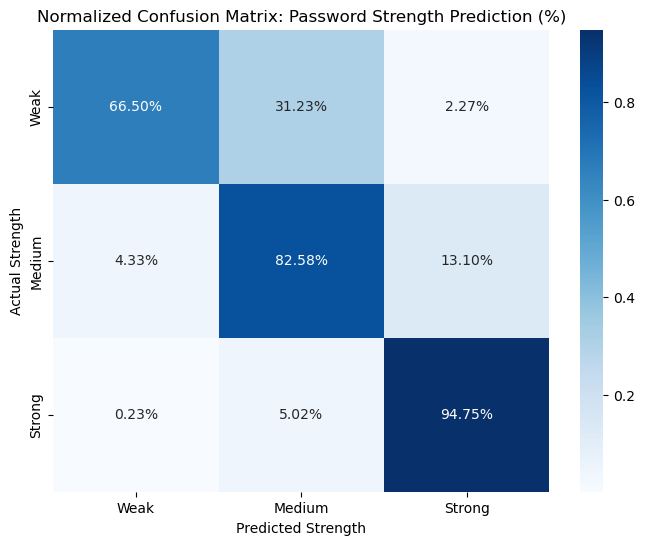

In [46]:
#confusion matrix
# Generate predictions
y_pred = final_model.predict(X_test)

# Compute Normalized Confusion Matrix (by rows, i.e., true labels)
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['Weak', 'Medium', 'Strong'], 
            yticklabels=['Weak', 'Medium', 'Strong'])

plt.title('Normalized Confusion Matrix: Password Strength Prediction (%)')
plt.ylabel('Actual Strength')
plt.xlabel('Predicted Strength')
plt.show()

In [65]:
# 1. Get the raw probabilities instead of the final labels
# This returns an array where each row has 3 values [Prob_0, Prob_1, Prob_2]
y_probs = final_model.predict_proba(X_test)

# 2. Extract the probability for Class 0 (Weak)
weak_probs = y_probs[:, 0]

# 3. Apply a custom threshold (e.g., 0.3 instead of the default 0.33/0.5)
# If the probability of being Weak is > 30%, we label it 0.
# Otherwise, we take the highest probability among the other classes.
custom_preds = []
for i in range(len(y_probs)):
    if y_probs[i, 0] >= 0.42:
        custom_preds.append(0) # Force label as Weak
    else:
        # Otherwise, pick the best of the remaining (Medium or Strong)
        custom_preds.append(np.argmax(y_probs[i]))

# 4. Check the new results
from sklearn.metrics import classification_report
print("--- CUSTOM THRESHOLD REPORT (Threshold = 0.42) ---")
print(classification_report(y_test, custom_preds))

--- CUSTOM THRESHOLD REPORT (Threshold = 0.42) ---
              precision    recall  f1-score   support

           0       0.83      0.74      0.78     27990
           1       0.80      0.77      0.78     39978
           2       0.76      0.95      0.85     19912

    accuracy                           0.80     87880
   macro avg       0.80      0.82      0.80     87880
weighted avg       0.80      0.80      0.80     87880



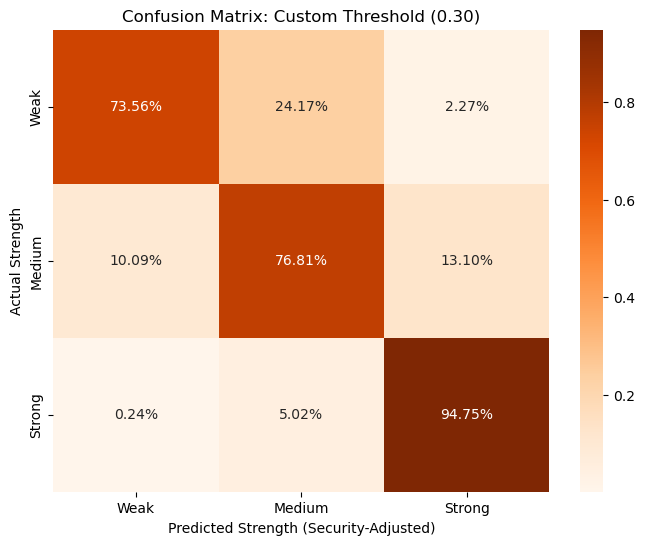

In [64]:
# 1. Compute the confusion matrix using your custom threshold predictions
cm_custom = confusion_matrix(y_test, custom_preds, normalize='true')

# 2. Plotting the Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_custom, annot=True, fmt='.2%', cmap='Oranges', 
            xticklabels=['Weak', 'Medium', 'Strong'], 
            yticklabels=['Weak', 'Medium', 'Strong'])

plt.title('Confusion Matrix: Custom Threshold (0.30)')
plt.ylabel('Actual Strength')
plt.xlabel('Predicted Strength (Security-Adjusted)')
plt.show()

In [68]:
# This should always be TRUE
assert np.all(
    final_model.predict(X_test)
    == np.argmax(final_model.predict_proba(X_test), axis=1)
)

print("✔ Model unchanged — thresholding is post-processing only")


✔ Model unchanged — thresholding is post-processing only


In [70]:
#saving model for js compatiobility
final_model.get_booster().save_model("password_strength_xgb.json")


In [71]:
#saving for python only
import joblib
joblib.dump(final_model, 'password_strength_model_FFinal.pkl')

['password_strength_model_FFinal.pkl']

In [72]:
import json

inference_config = {
    "classes": ["Weak", "Medium", "Strong"],
    "weak_threshold": 0.42,
    "decision_rule": "if P(Weak) >= threshold → Weak else argmax",
    "num_features": X_test.shape[1],
    "model": "XGBoost",
    "notes": "Security-adjusted post-processing threshold"
}

with open("inference_config.json", "w") as f:
    json.dump(inference_config, f, indent=4)
